In [16]:
import os
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Path to your saved .npz file
DATA_PATH = r"F:\WIDS-5.0\plant_disease_data.npz"

# Helper to split "Tomato___Bacterial_spot" into "Tomato"
def get_plant_type(label):
    return label.split('___')[0]

In [17]:
def load_preprocessed_data(filepath):
    print(f"Loading data from {filepath}...")
    data = np.load(filepath)
    X = data['X']
    y_diseases = data['y'] # These are the full labels (e.g., 'Tomato___Bacterial_spot')
    
    # Generate the Stage 1 labels (Plant Type) from the Stage 2 labels (Disease)
    # Example: "Tomato___Bacterial_spot" -> "Tomato"
    print("Generating plant labels...")
    y_plants = np.array([get_plant_type(label) for label in y_diseases])
    
    # Check if data needs scaling
    # If the max value is > 1, it implies it's still 0-255 and needs scaling
    if X.max() > 1.0:
        print("Scaling pixel values to 0-1 range...")
        X = X.astype('float32') / 255.0
    else:
        print("Data is already scaled.")
        
    return X, y_plants, y_diseases

# Execute Loading
if os.path.exists(DATA_PATH):
    X, y_plants, y_diseases = load_preprocessed_data(DATA_PATH)
    
    # Split everything together so indices match
    # Stratify by the DETAILED disease label to ensure rare diseases are in both sets
    X_train, X_test, y_plant_train, y_plant_test, y_dis_train, y_dis_test = train_test_split(
        X, y_plants, y_diseases, 
        test_size=0.2, 
        stratify=y_diseases, 
        random_state=42
    )

    print(f"Success! Loaded {len(X_train)} training samples.")
    print(f"Unique Plants: {len(np.unique(y_plants))}")
    print(f"Unique Diseases: {len(np.unique(y_diseases))}")
else:
    print(f"Error: File not found at {DATA_PATH}")

Loading data from F:\WIDS-5.0\plant_disease_data.npz...
Generating plant labels...
Scaling pixel values to 0-1 range...
Success! Loaded 43444 training samples.
Unique Plants: 14
Unique Diseases: 38


In [19]:
print("--- Training Stage 1: The Plant Router ---")

# This model learns to classify "Tomato" vs "Corn" vs "Apple"
router_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

router_model.fit(X_train, y_plant_train)

# Check Router Accuracy
router_acc = router_model.score(X_test, y_plant_test)
print(f"Stage 1 (Plant Classification) Accuracy: {router_acc:.4f}")

--- Training Stage 1: The Plant Router ---
Stage 1 (Plant Classification) Accuracy: 0.7289


In [20]:
print("--- Training Stage 2: The Disease Specialists ---")

specialist_models = {}
unique_plants = np.unique(y_plant_train)

for plant in unique_plants:
    # 1. Filter data: Get only images of this specific plant
    indices = (y_plant_train == plant)
    X_subset = X_train[indices]
    y_subset = y_dis_train[indices]
    
    # Only train if we have data (sanity check)
    if len(X_subset) < 10:
        print(f"Skipping {plant} (Not enough data)")
        continue

    print(f"Training Specialist for: {plant} ({len(X_subset)} samples)...")
    
    # 2. Train a specialized model
    # We use fewer trees (50) since these sub-datasets are smaller
    model = RandomForestClassifier(
        n_estimators=50, 
        random_state=42, 
        n_jobs=-1, 
        class_weight='balanced'
    )
    model.fit(X_subset, y_subset)
    
    # 3. Store in our dictionary
    specialist_models[plant] = model

print(f"\nSuccessfully trained {len(specialist_models)} specialist models.")

--- Training Stage 2: The Disease Specialists ---
Training Specialist for: Apple (2537 samples)...
Training Specialist for: Blueberry (1202 samples)...
Training Specialist for: Cherry_(including_sour) (1525 samples)...
Training Specialist for: Corn_(maize) (3081 samples)...
Training Specialist for: Grape (3249 samples)...
Training Specialist for: Orange (4405 samples)...
Training Specialist for: Peach (2125 samples)...
Training Specialist for: Pepper,_bell (1980 samples)...
Training Specialist for: Potato (1722 samples)...
Training Specialist for: Raspberry (297 samples)...
Training Specialist for: Soybean (4072 samples)...
Training Specialist for: Squash (1468 samples)...
Training Specialist for: Strawberry (1252 samples)...
Training Specialist for: Tomato (14529 samples)...

Successfully trained 14 specialist models.


In [21]:
def hierarchical_predict(X, router, specialists):
    # Step 1: Ask the Router what plant this is
    print("Step 1: Router predicting plant species...")
    plant_preds = router.predict(X)
    
    # Create empty array for final results
    final_predictions = np.empty(len(X), dtype=object)
    
    # Step 2: Route each sample to the correct specialist
    unique_predicted_plants = np.unique(plant_preds)
    
    print("Step 2: Routing to specialists...")
    for plant in unique_predicted_plants:
        if plant not in specialists:
            continue
            
        # Find all images the Router thinks are 'plant'
        indices = np.where(plant_preds == plant)[0]
        
        # Get the specialist for this plant
        specific_model = specialists[plant]
        
        # Predict disease using the specialist
        disease_preds = specific_model.predict(X[indices])
        
        # Store results
        final_predictions[indices] = disease_preds
        
    return final_predictions

# Run prediction on the Test Set
y_pred_final = hierarchical_predict(X_test, router_model, specialist_models)

Step 1: Router predicting plant species...
Step 2: Routing to specialists...


In [22]:
print("--- Final Evaluation: Hierarchical System ---")

# Calculate Accuracy
accuracy = accuracy_score(y_dis_test, y_pred_final)
print(f"Hierarchical Model Accuracy: {accuracy:.4f}")

# Detailed Report
print("\nClassification Report:")
print(classification_report(y_dis_test, y_pred_final, zero_division=0))

# Save the system for later
os.makedirs("models", exist_ok=True)
system = {
    "router": router_model,
    "specialists": specialist_models
}
joblib.dump(system, "models/hierarchical_system.joblib")
print("System saved to models/hierarchical_system.joblib")

--- Final Evaluation: Hierarchical System ---
Hierarchical Model Accuracy: 0.6142

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.79      0.12      0.21       126
                                 Apple___Black_rot       0.90      0.35      0.51       124
                          Apple___Cedar_apple_rust       0.00      0.00      0.00        55
                                   Apple___healthy       0.88      0.29      0.43       329
                               Blueberry___healthy       0.89      0.68      0.77       300
          Cherry_(including_sour)___Powdery_mildew       0.94      0.14      0.24       210
                 Cherry_(including_sour)___healthy       0.89      0.40      0.55       171
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.50      0.13      0.20       103
                       Corn_(maize)___Common_rust_       0.98    

Generating Deep-Dive Failure Report...


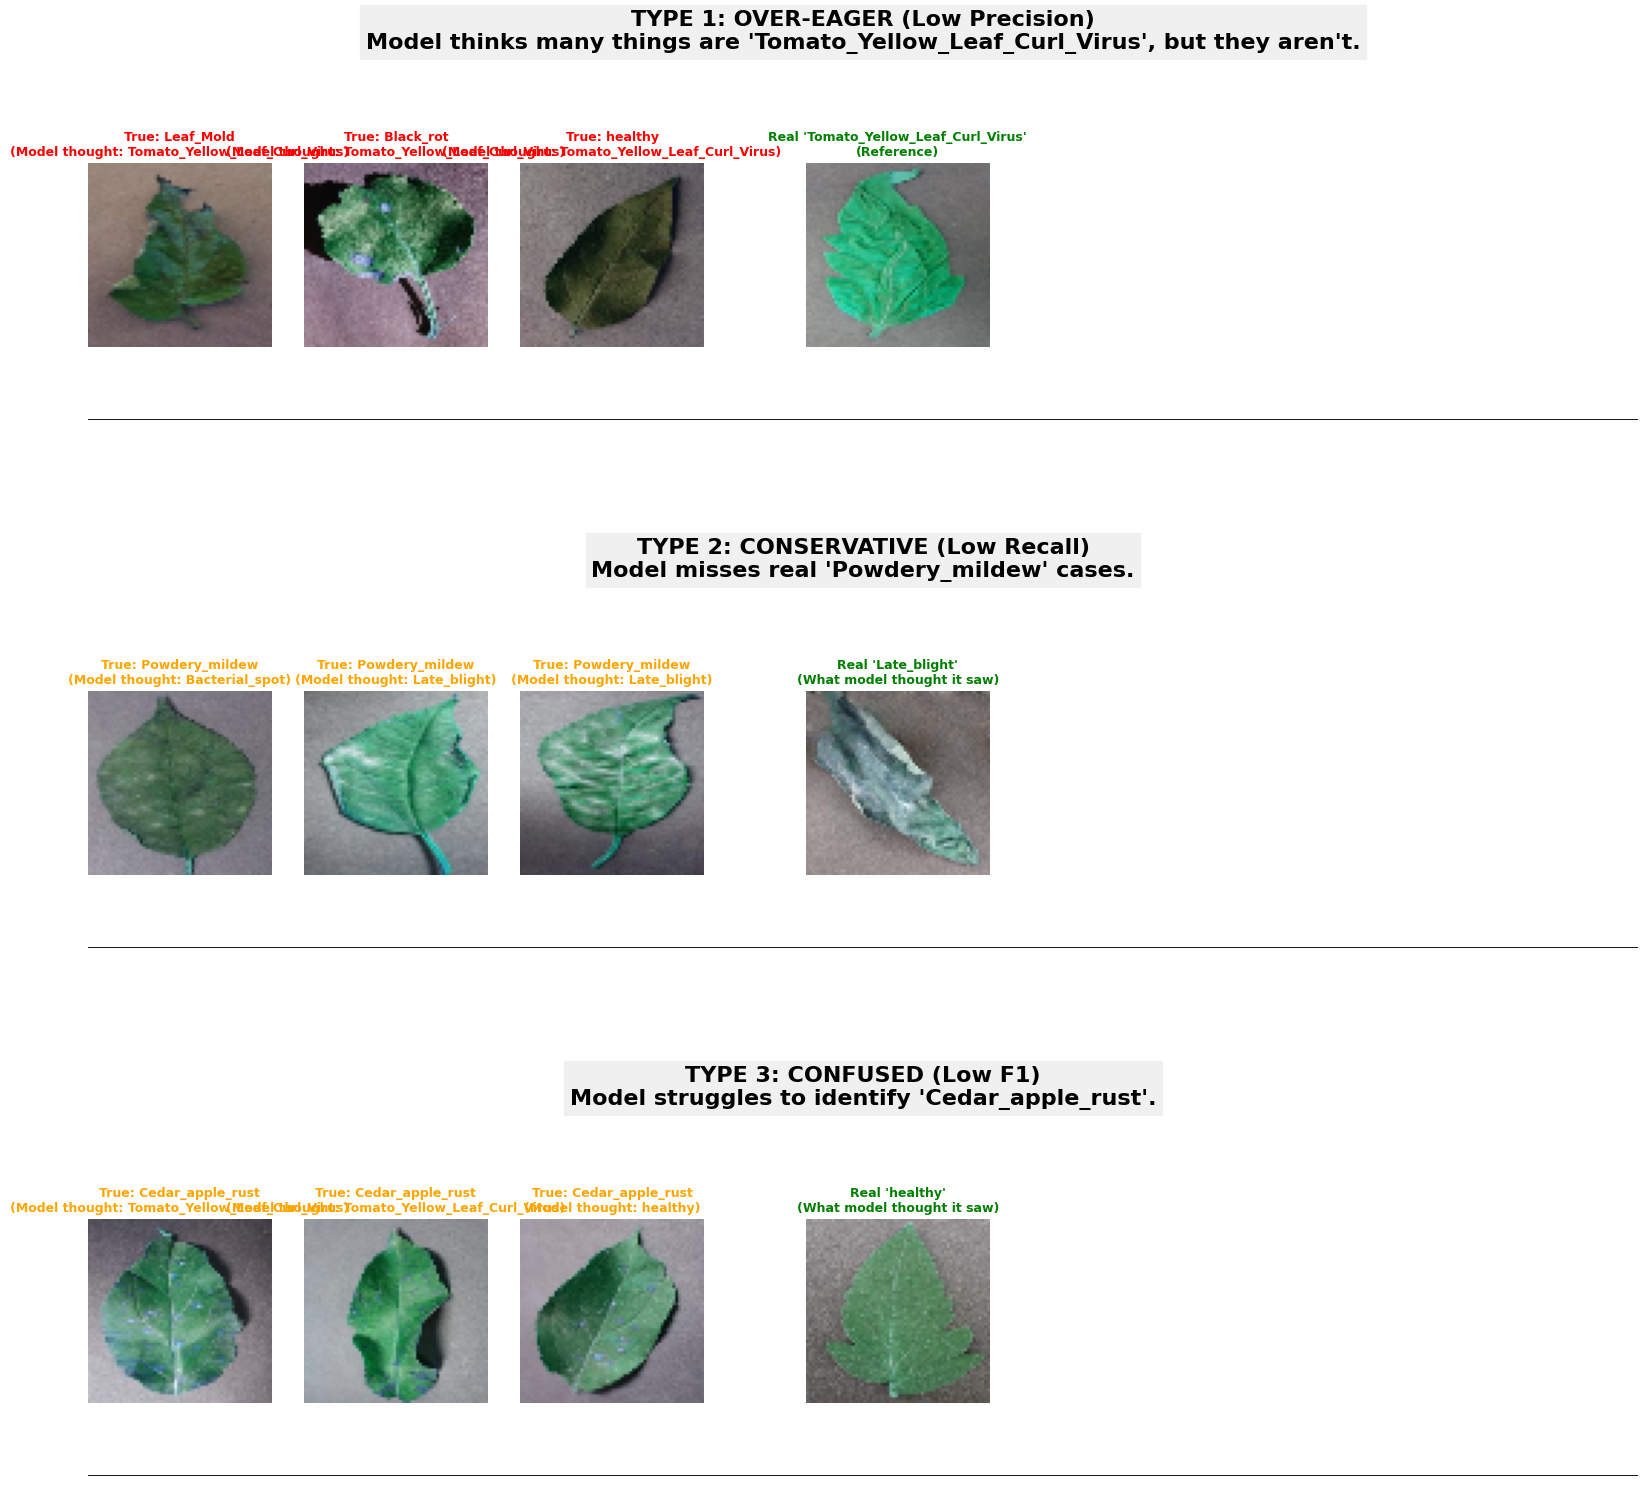

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

def get_reference_image(X_data, y_true, label):
    """Helper to find a real, correct example of a specific class."""
    indices = np.where(y_true == label)[0]
    if len(indices) > 0:
        return X_data[indices[0]] # Return the first valid example found
    return np.zeros_like(X_data[0]) # Fallback (black image)

def visualize_failures_with_reference(X_data, y_true, y_pred):
    print("Generating Deep-Dive Failure Report...")
    
    # 1. Identify the 3 interesting failure cases
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    df = pd.DataFrame(report).transpose()
    df = df[~df.index.isin(['accuracy', 'macro avg', 'weighted avg'])]
    
    # Case A: High Recall, Low Precision (The "Over-Eager" Class)
    df['diff_rec_prec'] = df['recall'] - df['precision']
    case_a = df.nlargest(1, 'diff_rec_prec').index[0]
    
    # Case B: High Precision, Low Recall (The "Conservative" Class)
    df['diff_prec_rec'] = df['precision'] - df['recall']
    case_b = df.nlargest(1, 'diff_prec_rec').index[0]
    
    # Case C: The "Confused" Class (Lowest F1)
    case_c = df.nsmallest(1, 'f1-score').index[0]
    
    cases = [
        (case_a, "OVER-EAGER (Low Precision)", 
         f"Model thinks many things are '{case_a.split('___')[-1]}', but they aren't."),
        
        (case_b, "CONSERVATIVE (Low Recall)", 
         f"Model misses real '{case_b.split('___')[-1]}' cases."),
        
        (case_c, "CONFUSED (Low F1)", 
         f"Model struggles to identify '{case_c.split('___')[-1]}'.")
    ]

    # 2. Plot Setup
    fig = plt.figure(figsize=(20, 18))
    # We use GridSpec to create clear rows
    gs = fig.add_gridspec(3, 1, hspace=0.6) 

    for row_idx, (target_class, title_short, description) in enumerate(cases):
        
        # Create a sub-grid for this row (1 row, 7 columns)
        # Cols 0-2: Failures | Col 3: Spacer | Cols 4-6: Comparisons
        inner_gs = gs[row_idx].subgridspec(1, 8, width_ratios=[1, 1, 1, 0.2, 1, 1, 1, 1])
        ax_title = fig.add_subplot(inner_gs[:])
        ax_title.axis('off')
        ax_title.set_title(f"TYPE {row_idx+1}: {title_short}\n{description}", 
                           fontsize=16, fontweight='bold', pad=30, backgroundcolor='#f0f0f0')

        # --- Logic for selecting samples ---
        # Find failures related to this class
        if "OVER-EAGER" in title_short:
            # False Positives: Pred = Target, True != Target
            indices = np.where((y_pred == target_class) & (y_true != target_class))[0]
            mode = "FP"
        else:
            # False Negatives: True = Target, Pred != Target
            indices = np.where((y_true == target_class) & (y_pred != target_class))[0]
            mode = "FN"

        # Select up to 3 samples
        if len(indices) == 0:
            continue
        samples = np.random.choice(indices, min(3, len(indices)), replace=False)

        # --- PLOT THE MISTAKES (Left Side) ---
        for i, idx in enumerate(samples):
            ax = fig.add_subplot(inner_gs[i])
            
            img = X_data[idx].reshape(64, 64, 3)
            if img.max() > 1.1: img = img.astype('uint8')
            
            ax.imshow(img)
            ax.axis('off')
            
            true_lbl = y_true[idx].split('___')[-1]
            pred_lbl = y_pred[idx].split('___')[-1]
            
            if mode == "FP":
                color = 'red' # Wrongly predicted as Target
                txt = f"True: {true_lbl}\n(Model thought: {pred_lbl})"
            else:
                color = 'orange' # Missed the Target
                txt = f"True: {true_lbl}\n(Model thought: {pred_lbl})"
                
            ax.set_title(txt, fontsize=9, color=color, fontweight='bold')

        # --- PLOT THE REFERENCE (Right Side) ---
        # Show what the Predicted Class *actually* looks like
        # This helps answer: "Why did the model confuse them?"
        
        # Pick the predicted label of the LAST sample to compare
        if mode == "FP":
            # For False Positive, Pred is Target. Show a Real Target.
            ref_label = target_class
            ref_title = f"Real '{target_class.split('___')[-1]}'\n(Reference)"
        else:
            # For False Negative, Pred is Something Else. Show that Something Else.
            ref_label = y_pred[samples[-1]] # Compare against the last error's prediction
            ref_title = f"Real '{ref_label.split('___')[-1]}'\n(What model thought it saw)"

        # Get Reference Image
        ref_img_flat = get_reference_image(X_data, y_true, ref_label)
        ref_img = ref_img_flat.reshape(64, 64, 3)
        if ref_img.max() > 1.1: ref_img = ref_img.astype('uint8')

        # Plot Reference in the 5th slot (after spacer)
        ax_ref = fig.add_subplot(inner_gs[4])
        ax_ref.imshow(ref_img)
        ax_ref.axis('off')
        ax_ref.set_title(ref_title, fontsize=9, color='green', fontweight='bold')
        
        # Add visual divider
        line = plt.Line2D([0, 1], [0, 0], transform=ax_title.transAxes, color='black', linewidth=2)
        ax_title.add_artist(line)

    plt.show()

# --- EXECUTE ---
visualize_failures_with_reference(X_test, y_dis_test, y_pred_final)